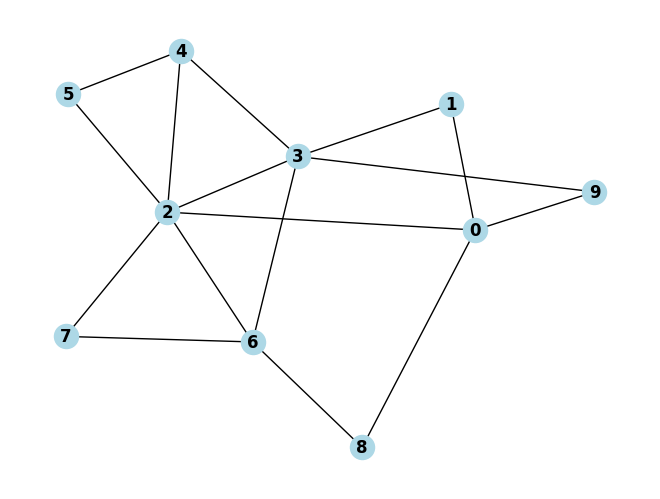

[18.75, 15.625, 12.5, 12.5, 9.375, 6.25, 6.25, 6.25, 6.25, 6.25]
Social Interaction created


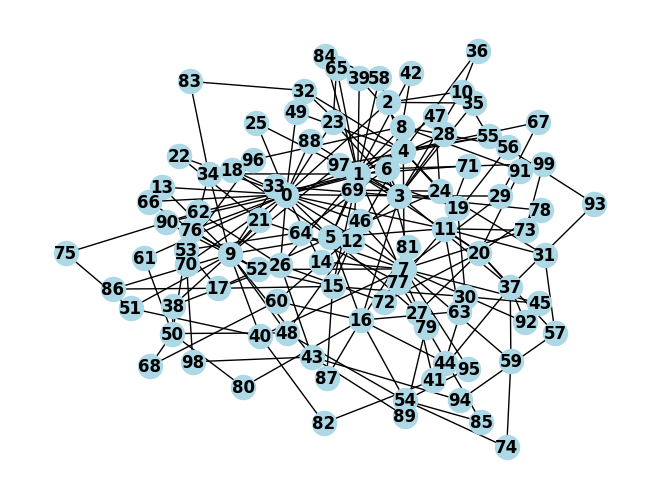

In [2]:
import random
import secrets
import networkx as nx
import matplotlib.pyplot as plt
import json
from datetime import datetime
import requests

NUMBER_OF_CARRIERS = 10
CARRIER_EDGE_ATTACHMENT = 2

NUMBER_OF_SUBSCRIBERS = 100
SUBSCRIBERS_EDGE_ATTACHMENT = 2

CONTRIBUTION_URL = 'http://127.0.0.1:5000/contribute'

class CDR:
    def __init__(self, src, dst, ts, prev, next) -> None:
        self.src = src
        self.dst = dst
        self.ts = ts
        self.prev = prev
        self.next = next;    

    
class Carrier:
    npa = None
    subscribers = []
    
    def __init__(self, id) -> None:
        self.id = "net" + str(id)
        self.npa = random.randint(200, 999)
        
    def contribute(self, cdr):
        prev = next = None
        
        if cdr.prev is not None:
            prev = cdr.prev.id
            
        if cdr.next is not None:
            next = cdr.next.id
            
        cci = f"{cdr.src}:{cdr.dst}:{cdr.ts}"
        tbc = f"{prev}|{self.id}|{cci}"
        tfc = f"{self.id}|{next}|{cci}"
        
        # make request to backend to submit cci, tbc, and tfc
        payload = { 'cci': cci, 'tbc': tbc, 'tfc': tfc }
        
        response = requests.post(CONTRIBUTION_URL, payload)
        
        if response.ok:
            # print(f"\n{self.id}\n\tcci\t=\t{cci}\n\ttbc\t=\t{tbc}\n\ttfc\t=\t{tfc}")
            return True
        else:
            # print(f"\n{self.id} failed to submit record")
            return False


class UserPopulation:
    number_of_phone_users = NUMBER_OF_SUBSCRIBERS
    number_of_attachment_edges = SUBSCRIBERS_EDGE_ATTACHMENT
    
    interaction = {}
    subscribers = []
    
    def __init__(self) -> None:
        self.create_structure()

        
    def create_structure(self):
        self.interaction = nx.barabasi_albert_graph(
            self.number_of_phone_users, 
            self.number_of_attachment_edges
        )
        print("Social Interaction created")
        draw_graph(self.interaction)
        
    
    def assign_subscribers_by_market_share(self, carrier, market_share):
        subscribers_count = round(self.number_of_phone_users * market_share)
        
        for i in range(subscribers_count):
            self.subscribers.append(self.make_phone(carrier.npa))
            
    
    def make_phone(self, npa):
        nxx = random.randint(100, 999)
        num = random.randint(1000, 9999)
        return f"{npa}-{nxx}-{num}"
    
    
    def shuffle(self):
        # Fisher-Yates shuffle algorithm
        for i in reversed(range(1, len(self.subscribers))):
            j = secrets.randbelow(i + 1)
            self.subscribers[i], self.subscribers[j] = self.subscribers[j], self.subscribers[i]


class Network:
    same_network_call = 0
    cross_network_call = 0
    
    market_shares = []
    number_of_carriers = NUMBER_OF_CARRIERS
    number_of_attachment_edges = CARRIER_EDGE_ATTACHMENT
    
    carriers = []
    npa_lookups = {}
    topology = None

    def __init__(self):
        self.create_topology()
        self.generate_market_shares()
        
        
    def create_topology(self):
        G = nx.barabasi_albert_graph(self.number_of_carriers, self.number_of_attachment_edges)

        for u, v, d in G.edges(data=True):
            d['weight'] = random.randint(1, 10)

        self.topology = G
        
        counter = 0
        while (counter < self.number_of_carriers):
            carrier = Carrier(counter)
            self.carriers.append(carrier)
            self.npa_lookups[str(carrier.npa)] = counter
            counter += 1
            
        draw_graph(G)
            

    def simulate_call(self, src, dst):
        """
        Simulate phone call between src and dst
        1. Find the shortest path between provider for src and provider for dst
        2. Create Cdr records for each carrier
        3. Simulate submission
        """
        
        src_npa = src[:3]
        dst_npa = dst[:3]
        
        if src_npa == dst_npa:
            self.same_network_call += 1
            return
        
        originator = self.npa_lookups.get(src_npa)
        terminator = self.npa_lookups.get(dst_npa)
        
        # Find the call path
        call_path = nx.shortest_path(self.topology, source=originator, target=terminator, weight='weight')
        
        # Map integer based indices to real carrier pointers 
        call_path = list(map(lambda id: self.carriers[id], call_path))
        
        for (index, carrier) in enumerate(call_path):
            prev = next = None
            
            if index > 0: 
                prev = call_path[index - 1]
                
            if index < len(call_path) - 1:
                next = call_path[index + 1]
                
            ts = round(datetime.now().timestamp())
            
            # create CDR log
            cdr = CDR(src=src, dst=dst, ts=ts, next=next, prev=prev)
            
            # Simulate record submission to traceback server
            carrier.contribute(cdr)
        
    
    def generate_market_shares(self):
        """
        Generate market shares for carriers. 
        This will be used for generating subscribers
        """
        total_degrees = 2 * len(self.topology.edges)
        
        for i in range(self.number_of_carriers):
            self.market_shares.append( self.topology.degree[i] / total_degrees)
        

def draw_graph(G):
    nx.draw(G, with_labels=True, node_color='lightblue', font_weight='bold')
    plt.show()
    
def to_json(data):
    return json.dumps(data, indent=4)

def show_market_shares(shares):
    print(sorted(list(map(lambda share: share * 100, shares)), reverse=True))
    
if __name__ == '__main__':
    telephony = Network()
    show_market_shares(telephony.market_shares)
    population = UserPopulation()
    
    for (i, carrier) in enumerate(telephony.carriers):
        population.assign_subscribers_by_market_share(carrier, telephony.market_shares[i])
        
    population.shuffle()
    
    def simulate():
        counter = 0
        while counter < population.number_of_phone_users:
            interactions = list(population.interaction.adj[counter])
            print(f"interactions: {interactions}")
            for person in interactions:
                # print(f"person: {person}")
                # print(f"SUBS: {len(population.subscribers)}")
                try:
                    src = population.subscribers[counter]
                    dst = population.subscribers[person]
                    
                    telephony.simulate_call(src, dst)
                except: Exception
            counter += 1
            
    # simulate()
        
        
    